## OCOM5203M Practical Assignment 2 - Image Caption Generation [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image to text model.
> 3. Use and compare two different text similarity metrics for evaluating an image to text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you would like to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using Python and PyTorch, and refer to the notebooks and exercises provided.

This coursework will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of 5029 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5029.

To download the data:

> 1. **Images**: download the zip file "coco_subset_images.zip (812MB)" [here](https://leeds365-my.sharepoint.com/:f:/g/personal/scsrss_leeds_ac_uk/EnVzgHGd-fhIhTcnxdK5hawBpGQz9isq8Bo8-Xhlwf6uwQ?e=e3LEru).
> 2. **Reference captions**: on the COCO [download page](https://cocodataset.org/#download), download the file named "2017 Train/Val annotations (241MB)". 
> 3. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name or the automatic grading will be affected.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.


Final note:

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

In [ ]:
sc21st

Your full name:

In [ ]:
Sebastian Thomas

## Imports

Feel free to add to this section as needed.

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from collections import Counter
import os
import numpy as np
import os
import re
import json
import glob
from collections import Counter
from tqdm import tqdm
import nltk.translate.bleu_score as bleu
from PIL import Image


Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use an RNN). 

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.

![Encoder Decoder](encoder_decoder_diagramv2022.png)

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks. 

We will first extract the feature representations of the images from the Encoder and save them (Part 1). During training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity



## 1 Extracting image features [11 marks]

### 1.1 EncoderCNN

Read through the template EncoderCNN class below and complete the class.

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        self.new_resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.new_resnet(images)
        return features

In [6]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

EncoderCNN(
  (new_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

### 1.2 Processing the images

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [7]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [9]:
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Artificial Intelligence CW2/coco_subset_images', transform=data_transform)

In [10]:
img_list = []
for image in dataset.imgs:
  filename = image[0].split('/')[-1]
  img_list.append(filename)

In [12]:
feature = []
encoder.eval()

with torch.no_grad():
  for data in tqdm(dataset):
    input_s, label_s = data
    inputs = input_s.to(device)
    outputs = encoder(inputs.unsqueeze(0))
    feature.extend(outputs.cpu().numpy())

100%|██████████| 5032/5032 [12:39<00:00,  6.63it/s]


In [13]:
features = (np.array(feature).squeeze(-1).squeeze(-1))
image_feature = dict(zip(img_list, features))

In [14]:
image_feature_list = []
for img, feature in zip(img_list, features):
  image_feature_list.append([img,feature])

In [15]:
torch.save(image_feature, '/content/drive/MyDrive/Artificial Intelligence CW2/features.pt')

In [16]:
df = pd.DataFrame(image_feature_list, columns=['file_name','img_features'])
df

,file_name,img_features
0,000000000009.jpg,"[0.33365238, 0.17291313, 1.5673909, 1.169334, ..."
1,000000000025.jpg,"[0.6931483, 0.24132304, 1.5080876, 0.17591073,..."
2,000000000030.jpg,"[0.45528504, 0.46287137, 1.1688311, 0.72200423..."
3,000000000034.jpg,"[0.7893482, 0.1520025, 0.9525262, 0.14337324, ..."
4,000000000036.jpg,"[1.323881, 0.07784522, 0.5731746, 0.43526247, ..."
...,...,...
5027,000000581906.jpg,"[0.89581764, 0.20499587, 0.12682478, 0.8798365..."
5028,000000581909.jpg,"[2.3521307, 0.36471698, 0.49957, 0.16047013, 0..."
5029,000000581913.jpg,"[0.35374394, 0.42399028, 0.34206963, 0.1526095..."
5030,000000581921.jpg,"[1.2912096, 0.6843204, 0.26035896, 0.07581655,..."


## 2 Text preparation [23 marks]


### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="df_caption_set.png" alt="images matched to caption" width="700"/>

In [17]:
with open("/content/drive/MyDrive/Artificial Intelligence CW2/annotations/captions_train2017.json") as data:
    captions = json.load(data)
print(captions.keys())

dict_keys(['info', 'licenses', 'images', 'annotations'])


In [18]:
annotations_df = pd.DataFrame(captions["annotations"])
annotations_df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [19]:
meta_df = pd.read_csv("/content/drive/MyDrive/Artificial Intelligence CW2/coco_subset_meta.csv")
print(len(annotations_df))

meta_subset = meta_df[["id", "file_name"]]
meta_subset = meta_subset.rename(columns={"id": "image_id", "file_name": "filename"})
captions_df = pd.merge(annotations_df, meta_subset).drop_duplicates()

591753


### 2.2 Clean the captions

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.

In [20]:
regex = re.compile("[^a-zA-Z\s]")
captions_df["cleaned_caption"] = captions_df["caption"].apply(
    lambda x: regex.sub("", x.lower())
)

In [21]:
captions_df[["caption", "cleaned_caption"]].head(20)

,caption,cleaned_caption
0,An airplane with its landing wheels out landing.,an airplane with its landing wheels out landing
1,A plane that is taking off at an airport,a plane that is taking off at an airport
2,A man takes a picture of an airplane taking off.,a man takes a picture of an airplane taking off
3,A large jet takes off from an airport runway.,a large jet takes off from an airport runway
4,The airplane is taking off on the runway at th...,the airplane is taking off on the runway at th...
5,The young man is stirring his pot of food with...,the young man is stirring his pot of food with...
6,A man enjoys cooking food in a pan,a man enjoys cooking food in a pan
7,A smiling man is cooking in his kitchen.,a smiling man is cooking in his kitchen
8,A man smiles as he stirs his food in the pot.,a man smiles as he stirs his food in the pot
9,A boy smiles while holding a pot and spoon.,a boy smiles while holding a pot and spoon


### 2.3  Split the data

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [22]:
import random
import math

def split_ids(image_id_list, train=0.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [23]:
random.seed(2000)
train_split, valid_split, test_split = split_ids(captions_df["image_id"].unique())
train_df = captions_df[captions_df["image_id"].isin(train_split)]
valid_df = captions_df[captions_df["image_id"].isin(valid_split)]
test_df = captions_df[captions_df["image_id"].isin(test_split)]

print(len(train_df), len(valid_df), len(test_df))

17606 2510 5038


### 2.3 Building the vocabulary

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [24]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [25]:
voc = Vocabulary()

In [26]:
words = []

traincap = train_df["cleaned_caption"].tolist()
traincap = [caption.split(" ") for caption in traincap]

listofwords = words + [word for caption in traincap for word in caption]

validcap = valid_df["cleaned_caption"].tolist()
validcap = [caption.split(" ") for caption in validcap]

listofwords = listofwords + [word for caption in validcap for word in caption]

word_count = Counter(listofwords)
words = set({word: count for word, count in word_count.items() if count > 3})
words = [word for word in listofwords if word!=""]
print(len(words))

210162


In [27]:
for i in listofwords:
    voc.add_word(i)

### 2.4 The Dataset and DataLoader

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [28]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        self.df = df
        self.features = features
        self.vocab = vocab

    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """
        row = self.df.iloc[index]
        filename = row["filename"]
        feature = self.features[filename]
        caption = row["cleaned_caption"]
        caption = [self.vocab(word) for word in caption.split(" ")]
        caption.append(self.vocab("<end>"))
        true_length = len(caption)

        if len(caption) > 47:
            caption = caption[:46]
            caption.append(self.vocab("<end>"))
        else:
            for i in range(47 - len(caption)):
                caption.append(self.vocab("<pad>"))
        feature = feature.reshape((2048))
        caption = torch.tensor(caption[:47])

        return feature, caption, true_length, filename

    def __len__(self):
        return len(self.df)

In [29]:
features = torch.load("/content/drive/MyDrive/Artificial Intelligence CW2/features.pt", map_location=device)

In [30]:
train_set = COCO_Subset(df=train_df, features=features, vocab=voc)
valid_set = COCO_Subset(df=valid_df, features=features, vocab=voc)
test_set = COCO_Subset(df=test_df, features=features, vocab=voc)

In [31]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=False)

Load one batch of the training set and print out the shape of each returned Tensor.

In [32]:
train_iter = iter(train_loader)
features, captions, lengths, _ = train_iter.next()
print(features.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([64, 2048])
torch.Size([64, 47])
torch.Size([64])


## 3 Train DecoderRNN [15 marks]

### 3.1 Define the encoder model

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [40]:
max_seq_length=47
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512,num_layers=1,max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size, num_layers)

        # TO COMPLETE
        self.rnn = nn.LSTM(embed_size, hidden_size)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(
            embeddings, lengths.clamp(max=max_seq_length), batch_first=True, enforce_sorted=False
        )
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens.data)  # hiddens[0]
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(
                inputs, states
            )  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(
                hiddens.squeeze(1)
            )  # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)  # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)  # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(
            sampled_ids, 1
        )  # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [34]:
torch.manual_seed(2000)
decoder = DecoderRNN(len(voc)).to(device)

### 3.2 Train the decoder

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [37]:
decoder = DecoderRNN(len(voc)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=voc("<pad>")).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=3e-4)

In [46]:
train_losses = []
valid_losses = []
valid_patience = 5
best_valid_loss = 1e3
epoch_val = 0
num_epochs = 300

In [47]:
loss_not_improved = 0
for e in range(epoch_val, num_epochs + epoch_val):
    # Training
    decoder.train()
    train_epoch = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Training: {e+1} / {num_epochs+epoch_val}",)
    train_loss = 0

    for i, (features, captions, lengths, _) in train_epoch:
        optimizer.zero_grad()
        features = features.to(device)
        captions = captions.to(device)
        lengths = lengths.cpu()
        outputs = decoder(features, captions, lengths)
        targets = pack_padded_sequence(
            captions, lengths, batch_first=True, enforce_sorted=False)
        loss = criterion(outputs, targets[0])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        epoch_val = e
        train_epoch.set_postfix({"train_loss": f"{train_loss / (i+1):.5f}"})
    train_losses.append(train_loss / len(train_loader))

    # Validation
    decoder.eval()
    validep = tqdm(
        enumerate(valid_loader), total=len(valid_loader), desc="Validation")
    valid_loss = 0
    for i, (features, captions, lengths, _) in validep:
        features = features.to(device)
        captions = captions.to(device)
        lengths = lengths.cpu()
        outputs = decoder(features, captions, lengths)
        targets = pack_padded_sequence(
            captions, lengths, batch_first=True, enforce_sorted=False)
        loss = criterion(outputs, targets[0])
        valid_loss += loss.item()
        validep.set_postfix({"valid_loss": f"{valid_loss / (i+1):.5f}"})
    valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        loss_not_improved = 0
        valfeature = {
            "epoch": e,
            "model_state_dict": decoder.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": valid_loss,}
        torch.save(valfeature, "/content/drive/MyDrive/Artificial Intelligence CW2/feature.pth")
        print(f"Validation feature saved with loss {valid_loss:.5f}...")
    else:
        loss_not_improved += 1
    if loss_not_improved > valid_patience:
        print("\nNot Improving. Stopping training.")
        break

Validation: 100%|██████████| 40/40 [00:01<00:00, 27.76it/s, valid_loss=3.54174]


Validation feature saved with loss 3.54174...


Validation: 100%|██████████| 40/40 [00:01<00:00, 28.14it/s, valid_loss=3.43725]


Validation feature saved with loss 3.43725...


Validation: 100%|██████████| 40/40 [00:01<00:00, 27.54it/s, valid_loss=3.35555]


Validation feature saved with loss 3.35555...


Validation: 100%|██████████| 40/40 [00:01<00:00, 28.27it/s, valid_loss=3.29728]


Validation feature saved with loss 3.29728...


Validation: 100%|██████████| 40/40 [00:01<00:00, 28.04it/s, valid_loss=3.25543]


Validation feature saved with loss 3.25543...


Validation: 100%|██████████| 40/40 [00:01<00:00, 28.09it/s, valid_loss=3.22521]


Validation feature saved with loss 3.22521...


Validation: 100%|██████████| 40/40 [00:01<00:00, 28.18it/s, valid_loss=3.20177]


Validation feature saved with loss 3.20177...


Validation: 100%|██████████| 40/40 [00:01<00:00, 27.57it/s, valid_loss=3.18324]


Validation feature saved with loss 3.18324...


Validation: 100%|██████████| 40/40 [00:01<00:00, 28.24it/s, valid_loss=3.22541]


Not Improving. Stopping training.


Best validation loss: 3.18324


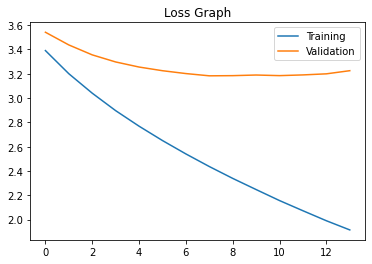

In [48]:
print(f"Best validation loss: {valfeature['loss']:.5f}")

plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.title('Loss Graph')
plt.legend()
plt.show()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [49]:
feature = torch.load("/content/drive/MyDrive/Artificial Intelligence CW2/feature.pth")
decoder = DecoderRNN(len(voc)).to(device)
decoder.load_state_dict(valfeature["model_state_dict"])
decoder.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(6539, 256, padding_idx=1)
  (rnn): LSTM(256, 512)
  (linear): Linear(in_features=512, out_features=6539, bias=True)
)

In [50]:
features = []
captions = []
lengths = []
filenames = []

for i, (feature, caption, length, filename) in enumerate(test_loader):
    features.append(feature[0])
    captions.append(caption[0])
    lengths.append(length[0])
    filenames.append(filename[0])
    
    if i >= 4:
        break

In [51]:
def get_caption_from_output(output, vocab):
    words = [torch.argmax(i) for i in output]
    words = [word for word in words if word not in [torch.tensor(0), torch.tensor(1), torch.tensor(2)]]
    caption = ' '.join([vocab.idx2word[int(word)] for word in words])
    return caption

In [53]:
outputs = {}
for i in range(len(filenames)):
    feature = features[i].unsqueeze(0).to(device)
    caption = captions[i].unsqueeze(0).to(device)
    length = lengths[i].unsqueeze(0).cpu()
    output = decoder(feature, caption, length)
    caption = get_caption_from_output(output, voc)
    outputs[filenames[i]] = caption
print(outputs)

{'000000410627.jpg': 'a man woman is holding a hair out food a pizza spoon', '000000540860.jpg': 'a green and parked a in to a street street', '000000079920.jpg': 'a desk room with a couch television and a', '000000314370.jpg': 'a kitchen with with lots and and a appliances', '000000554749.jpg': 'a with a sink mirror sink sink and a sink'}


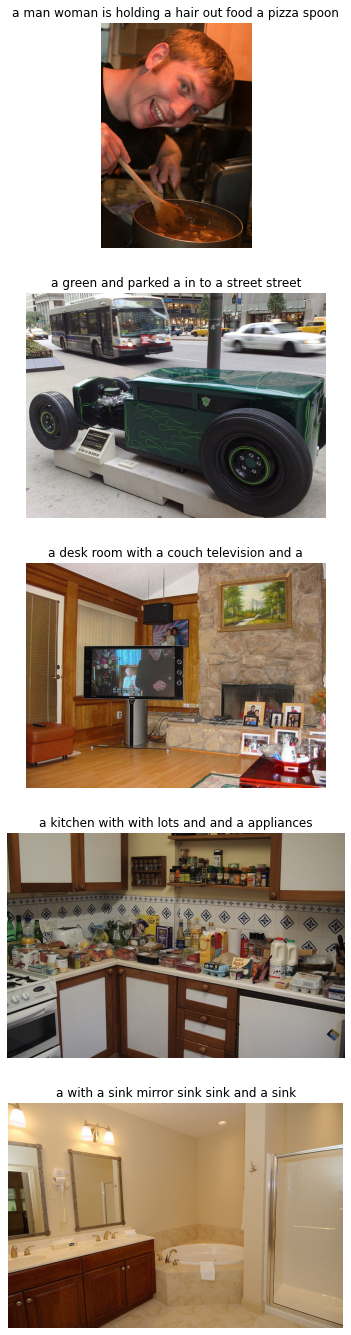

In [54]:
fig, ax = plt.subplots(5,1)
fig.set_size_inches(18, 24)
img_dir = '/content/drive/MyDrive/Artificial Intelligence CW2/coco_subset_images/images'
for i, filename in enumerate(outputs.keys()):
    img = Image.open(os.path.join(img_dir, filename))
    ax[i].imshow(img)
    ax[i].set_title(outputs[filename])
    ax[i].axis("off")

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

###  5.1 BLEU score


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
bleuscores = []

for i, (features, captions, lengths, filenames) in tqdm(enumerate(test_loader), total=len(test_loader)):
    features, captions = features[0].unsqueeze(0).to(device), captions[0].unsqueeze(0).to(device)
    lengths = lengths[0].unsqueeze(0)
    outputs = decoder(features, captions, lengths)

    predicted_caption = get_caption_from_output(outputs, voc)
    filename = list(set(filenames))[0]

    original_captions = test_df[test_df["filename"] == filename]["cleaned_caption"].tolist()
    original_captions = [cap.strip().split(' ') for cap in original_captions]

    smoothing = bleu.SmoothingFunction().method7
    bleu_score = bleu.sentence_bleu(original_captions, predicted_caption, smoothing_function=smoothing)

    bleu_score = max(0, bleu_score)
    bleu_score = min(1, bleu_score)

    bleuscores.append({
        "filename": filename,
        "bleu_score": bleu_score,
        "original_captions": original_captions,
        "predicted_caption": predicted_caption,
    })

Mean BLEU score: 0.33


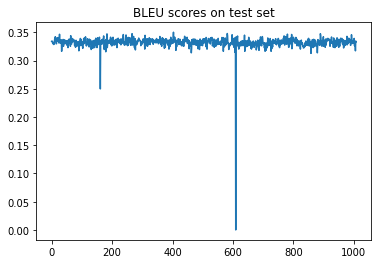

In [56]:
bs = [sc["bleu_score"] for sc in bleuscores]

print(f"Mean BLEU score: {sum(bs) / len(bs):.2f}")
plt.plot(bs)
plt.title("BLEU scores on test set")
plt.show()

### 5.2 BLEU score examples

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [57]:
bleu = sorted(bleuscores, key=lambda x: x["bleu_score"])

low_score = bleu[0]
high_score = bleu[-3]

In [58]:
print("Low Score")
print(f"BLEU Score: {low_score['bleu_score']:.4f}")
print("\nOriginal Captions:")
for caption in low_score["original_captions"]:
    print(' '.join(caption))
print("\nPredicted Caption:", ' '.join(low_score["predicted_caption"]))

print("\nHigh Score")

print(f"BLEU Score: {high_score['bleu_score']:.4f}")
print("\nOriginal Captions:")
for caption in high_score["original_captions"]:
    print(' '.join(caption))
print("\nPredicted Caption:", ' '.join(high_score["predicted_caption"]))

Low Score
BLEU Score: 0.0000

Original Captions:
three people on horseback with the horse rearing
two people that are riding two horses together
three horses with riders are standing on their back legs in an arena
rodeo horse riders are holding on for the crowd as the horses dance
there are people watching three men on horseback

Predicted Caption: a   i s   t w o   r i d i n g   a   h o r s e s   r i d i n g   t h e   w i t h

High Score
BLEU Score: 0.3477

Original Captions:
a woman using a desktop computer mouse on top of a desk
a view from overhead of a person using a mouse at a computer on a desk covered with various electronics
a person controlling a mouse at a computer
a person at a desk with a keyboard cell phone mouse and mp player
a computer user sits at a desk surrounded b various forms of technology

Predicted Caption: a   p e r s o n   i s   a   l a p t o p   c o m p u t e r   o n   a   o f   a   t a b l e


## 6 Caption evaluation using cosine similarity [12 marks]

###  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [59]:
getwrd = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intr = set(vec1.keys()) & set(vec2.keys())
    num = sum([vec1[x] * vec2[x] for x in intr])
    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    den = math.sqrt(sum1) * math.sqrt(sum2)
    if not den:
        return 0.0
    else:
        return float(num) / den

In [60]:
def text_to_vector(text):
    findwrd = getwrd.findall(text)
    return Counter(findwrd)

In [61]:
for i in tqdm(bleuscores):
    predicted_caption = ' '.join(i["predicted_caption"])
    tmp_score = 0
    for caption in i["original_captions"]:
        original_caption = ' '.join(caption)
        vec1 = text_to_vector(original_caption)
        vec2 = text_to_vector(predicted_caption)
        cos_sin = get_cosine(vec1, vec2)
        tmp_score += cos_sin

    avgcosscore = tmp_score / len(i["original_captions"])
  
    i["cosine_score"] = avgcosscore

100%|██████████| 1008/1008 [00:00<00:00, 5929.80it/s]


Mean Cosine similarity: 0.2112


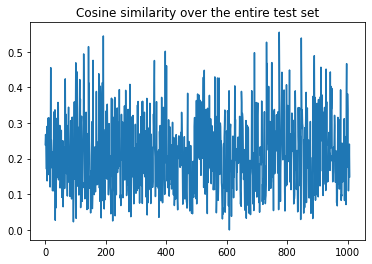

In [62]:
cosscore = [score["cosine_score"] for score in bleuscores]

print(f"Mean Cosine similarity: {sum(cosscore) / len(cosscore):.4f}")
plt.plot(cosscore)
plt.title("Cosine similarity over the entire test set")
plt.show()

#### 6.2 Cosine similarity examples 

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [63]:
cosine = sorted(bleuscores, key=lambda x: x["cosine_score"])

low_score = cosine[0]
high_score = cosine[-3]

In [64]:
print("Low Score")

print(f"Cosine Score: {low_score['cosine_score']:.3f}")
print("\nOriginal Captions:")
for i in low_score["original_captions"]:
    print(' '.join(i))
print("\nPredicted Caption:", ' '.join(low_score["predicted_caption"]))

print("\nHigh Score")

print(f"Cosine Score: {high_score['cosine_score']:.3f}")
print("\nOriginal Captions:")
for i in high_score["original_captions"]:
    print(' '.join(i))
print("\nPredicted Caption:", ' '.join(high_score["predicted_caption"]))

Low Score
Cosine Score: 0.000

Original Captions:
three people on horseback with the horse rearing
two people that are riding two horses together
three horses with riders are standing on their back legs in an arena
rodeo horse riders are holding on for the crowd as the horses dance
there are people watching three men on horseback

Predicted Caption: a   i s   t w o   r i d i n g   a   h o r s e s   r i d i n g   t h e   w i t h

High Score
Cosine Score: 0.538

Original Captions:
a person sitting on a bed holding a wii controller and looking at a television
boy playing a video game while a dog sits on a bench near by
a man sitting on a chair playing video games
a boy sits near a dog while watching television
a man with a dog plays a game on his wii

Predicted Caption: a   m a n   i s   a   o n   a   b e a c h   o f   a   b e a c h


## 7 Comparing BLEU and Cosine similarity [16 marks]

### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [82]:
avgsc = 0
for score in bleuscores:
    scoredif = abs(score["bleu_score"] - score["cosine_score"])
    score["score_diff"] = scoredif
    avgsc += scoredif

avgsc /= len(bleuscores)

print(f"Average variation between BLEU and Cosine scores for the test set is: {avgsc:.3f}")

Average variation between BLEU and Cosine scores for the test set is: 0.135


 ### 7.2 Analysis of individual examples
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [ ]:
sortd = sorted(bleuscores, key=lambda x: x["score_diff"])
low_diff = sortd[0]
high_diff = sortd[-3]

In [79]:
print("Low Variation")

print(f"BLEU Score: {low_diff['bleu_score']:.3f}")
print(f"Cosine Score: {low_diff['cosine_score']:.3f}")
print("\nOriginal Captions:")
for caption in low_diff["original_captions"]:
    print(' '.join(caption))
print("\nPredicted Caption:", ' '.join(low_diff["predicted_caption"]))

print("\nHigh Variation")

print(f"BLEU Score: {high_diff['bleu_score']:.3f}")
print(f"Cosine Score: {high_diff['cosine_score']:.3f}")
print("\nOriginal Captions:")
for caption in high_diff["original_captions"]:
    print(' '.join(caption))
print("\nPredicted Caption:", ' '.join(high_diff["predicted_caption"]))

Low Variation
BLEU Score: 0.000
Cosine Score: 0.000

Original Captions:
three people on horseback with the horse rearing
two people that are riding two horses together
three horses with riders are standing on their back legs in an arena
rodeo horse riders are holding on for the crowd as the horses dance
there are people watching three men on horseback

Predicted Caption: a   i s   t w o   r i d i n g   a   h o r s e s   r i d i n g   t h e   w i t h

High Variation
BLEU Score: 0.330
Cosine Score: 0.032

Original Captions:
a large group of people and a mascot with toothbrushes
a big beaver with a sweat suit on holding  two red tooth brushes
a costumed character with toothbrushes is amusing a crowd of children
there is a person in animal suit holding large toothbrushes
a man in a mascot outfit around some people

Predicted Caption: a   l i v i n g   i s   s i t t i n g   i n   i n   i n   t e l e v i s i o n   t h e   l i v i n g


### Overall quality [5 marks]

See the top of the notebook for submission instructions.